# **Gesture Recognition using Deep Learning**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
import random
import itertools
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import tensorflow
import tensorflow as tf
import shap


from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization,
    Flatten, Dense, Dropout,GaussianNoise, SpatialDropout1D, Input
)

from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict, Counter


np.random.seed(42)

## Preprocessing
Same procedure as Data Exploratory Code

In [ ]:
root_dir = "/content/drive/MyDrive/IA_EBM/PROJECT/EMG_data_for_gestures-master"
all_txt = glob.glob(os.path.join(root_dir, "**", "*.txt"), recursive=True)

dfs = []
for f in tqdm(all_txt, desc="Loading .txt files"):
    dfs.append(pd.read_csv(f, sep="\t"))
combined_df = pd.concat(dfs, ignore_index=True)


df = combined_df[(combined_df['class'] != 0) & (combined_df['class'] != 7)].reset_index(drop=True)

df['segment'] = (df['class'] != df['class'].shift()).cumsum()
gesture_datasets = {}
for (g_class, seg), group in tqdm(df.groupby(['class', 'segment']), desc="Segmenting gestures"):
    key = f"gesture_{int(g_class)}_{seg}"
    gesture_datasets[key] = group.drop(columns=['segment']).reset_index(drop=True)


classes = sorted({int(k.split('_')[1]) for k in gesture_datasets})
train_segs, val_segs, test_segs = [], [], []
for cls in tqdm(classes, desc="Splitting segments"):
    seg_keys = [k for k in gesture_datasets if int(k.split('_')[1]) == cls]
    random.shuffle(seg_keys)
    n = len(seg_keys)
    n_train = int(0.6 * n)
    n_val   = int(0.2 * n)
    train_segs += seg_keys[:n_train]
    val_segs   += seg_keys[n_train:n_train+n_val]
    test_segs  += seg_keys[n_train+n_val:]
print(f"Segments → train: {len(train_segs)}, val: {len(val_segs)}, test: {len(test_segs)}")


def extract_deterministic_windows(signal, window_size=400, step=100):   #FROM THE SECOND HYPERPARAMETER TUNNING
    return [signal[:, i:i+window_size]
            for i in range(0, signal.shape[1] - window_size + 1, step)]

train_w, val_w, test_w = {}, {}, {}
WINDOW_SIZE = 400

for key in tqdm(gesture_datasets, desc="Extracting windows"):
    gdf = gesture_datasets[key]
    cols = [c for c in gdf.columns if c.startswith("channel")]
    sig  = gdf[cols].to_numpy().T   # (channels, samples)

    # choose step based on split
    if key in train_segs:
        step = 100               # 75% overlap for training
        target = train_w
    else:
        step = WINDOW_SIZE       # no overlap for val/test
        target = val_w if key in val_segs else test_w

    # slide window
    for i in range(0, sig.shape[1] - WINDOW_SIZE + 1, step):
        w = sig[:, i : i + WINDOW_SIZE]
        target[f"{key}_win_{i//step}"] = w


print("Train windows:", len(train_w),
      "Val windows:",   len(val_w),
      "Test windows:",  len(test_w))



def extract_label(k):
    return int(k.split('_')[1])

def prepare(wdict):
    X = np.stack([w.T for w in wdict.values()], axis=0)  # (n_samples, window, channels)
    y = np.array([extract_label(k) for k in wdict.keys()])
    return X, y

X_train, y_train = prepare(train_w)
X_val,   y_val   = prepare(val_w)
X_test,  y_test  = prepare(test_w)



mean = X_train.mean(axis=(0,1), keepdims=True)
std  = X_train.std(axis=(0,1), keepdims=True) + 1e-8
for arr in tqdm((X_train, X_val, X_test), desc="Normalizing datasets"):
    arr[:] = (arr - mean) / std



classes     = np.unique(y_train)
num_classes = len(classes)
offset      = classes.min()
y_train_enc = to_categorical(y_train - offset, num_classes)
y_val_enc   = to_categorical(y_val   - offset, num_classes)
y_test_enc  = to_categorical(y_test  - offset, num_classes)



Splitting segments: 100%|██████████| 6/6 [00:00<00:00, 1707.43it/s]


Segments → train: 516, val: 168, test: 180


Extracting windows: 100%|██████████| 864/864 [00:00<00:00, 1764.30it/s]


Train windows: 7135 Val windows: 638 Test windows: 692


Normalizing datasets: 100%|██████████| 3/3 [00:00<00:00, 10.77it/s]


## Inference Mode Evaluation

During training, layers like Dropout and BatchNormalization behave differently than at inference time:

- **Dropout** randomly deactivates units.
- **BatchNormalization** uses batch statistics rather than the running averages used during deployment.

To get a realistic view of how our model will perform in production, we evaluate it in **inference mode** (using `model.evaluate()`).

This ensures:
- Consistent and stable accuracy readings.
- No misleading performance due to training-phase randomness.
- Accurate tracking of true generalization to validation data.


In [ ]:
class EvalTrainVal(Callback):
    def __init__(self, train_data, val_data):
        super().__init__()
        self.train_data = train_data
        self.val_data   = val_data
        self.eval_metrics = {'train_acc': [], 'val_acc': []}

    def on_epoch_end(self, epoch, logs=None):
        # run inference‐mode eval on both
        _, tr_acc = self.model.evaluate(*self.train_data, verbose=0)
        _, va_acc = self.model.evaluate(*self.val_data,   verbose=0)
        self.eval_metrics['train_acc'].append(tr_acc)
        self.eval_metrics['val_acc'].append(va_acc)
        print(f" — eval_train_acc: {tr_acc:.4f}, eval_val_acc: {va_acc:.4f}")

In [ ]:
timesteps, n_channels = X_train.shape[1], X_train.shape[2]
num_classes = y_train_enc.shape[1]

## Build and Compile the 1D-CNN Model

After building this CNN model, we really struggled with overfitting.

To improve generalization and reduce overfitting, beside reducing the general complexity of the model, we apply several regularization techniques throughout the network:

- **L2 Regularization (Weight Decay):**  
  Applied to all convolutional and dense layers to penalize large weights and encourage simpler, more robust models.

- **Dropout & SpatialDropout1D:**  
  We use `Dropout` after dense layers and `SpatialDropout1D` in convolutional layers. This randomly deactivates parts of the network during training, reducing reliance on specific neurons and preventing co-adaptation.

- **Batch Normalization:**  
  Added after convolutional layers to stabilize training and provide regularization by reducing internal covariate shift.

- **EarlyStopping:**  
  Training stops automatically if validation loss doesn't improve for a set number of epochs, preventing the model from overfitting to the training data in later stages.

- **ReduceLROnPlateau:**  
  If the validation loss plateaus, the learning rate is reduced to allow the optimizer to make finer adjustments. This can help escape flat regions or local minima without overfitting.

- **Segment-wise Data Splitting:**  
  Instead of randomly splitting windows, we split at the gesture segment level. This ensures that no part of a single gesture appears in both training and validation/test sets, eliminating data leakage.


In [ ]:
def build_model(filters, kernel_size, dropout_rate, weight_decay, dense_units, lr):
    """
    Build and compile a 1D-CNN with the given hyperparameters.
    """
    model = Sequential([
        Input(shape=(timesteps, n_channels)),

        Conv1D(filters, kernel_size,
               activation='relu', kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        SpatialDropout1D(dropout_rate),

        Conv1D(filters, kernel_size,
               activation='relu', kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(dropout_rate),

        Conv1D(filters * 2, kernel_size - 2,
               activation='relu', kernel_regularizer=l2(weight_decay)),
        MaxPooling1D(2),
        Dropout(dropout_rate),

        Flatten(),
        Dense(dense_units,
              activation='relu', kernel_regularizer=l2(weight_decay)),
        Dropout(dropout_rate),

        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

## Hyperparameter Search Loop
 - Iterates over filter sizes, kernel sizes, dropout rates,
  weight decay, dense units, and learning rates.

For the chose of parameters, we've not selected that with the highest performance in numerical terms but the one it had a most adequate accuracy curve.

Hyperparam search:   0%|          | 0/64 [00:00<?, ?it/s]

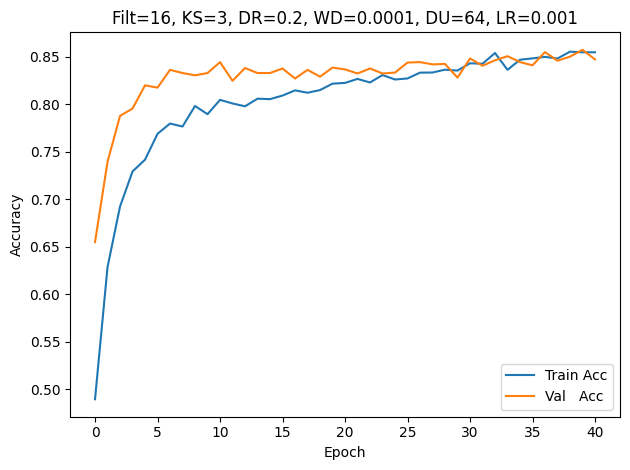

--> Best val_acc: 0.8572 for config: {'filters': 16, 'kernel_size': 3, 'dropout_rate': 0.2, 'weight_decay': 0.0001, 'dense_units': 64, 'lr': 0.001}



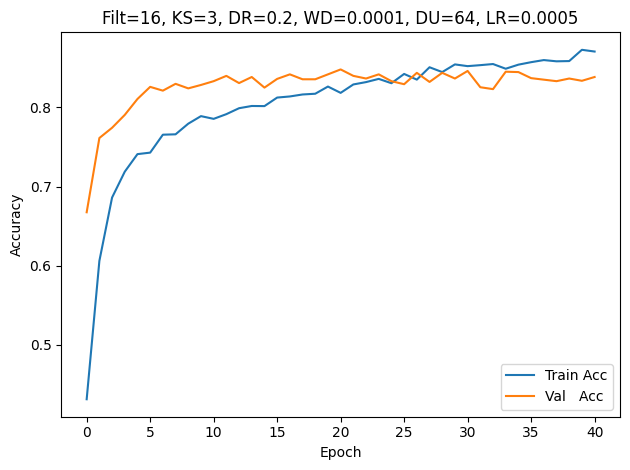

--> Best val_acc: 0.8481 for config: {'filters': 16, 'kernel_size': 3, 'dropout_rate': 0.2, 'weight_decay': 0.0001, 'dense_units': 64, 'lr': 0.0005}



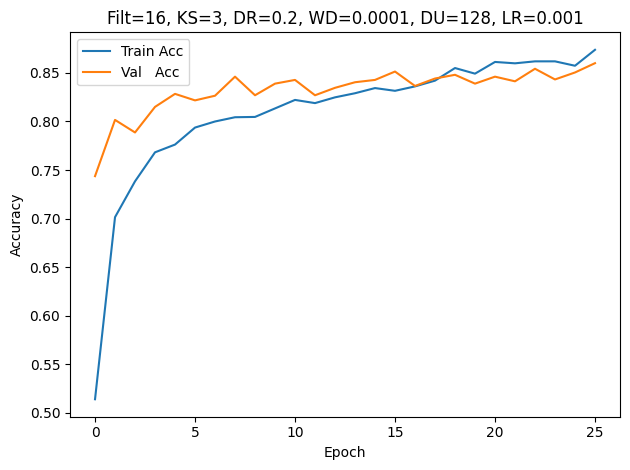

--> Best val_acc: 0.8601 for config: {'filters': 16, 'kernel_size': 3, 'dropout_rate': 0.2, 'weight_decay': 0.0001, 'dense_units': 128, 'lr': 0.001}



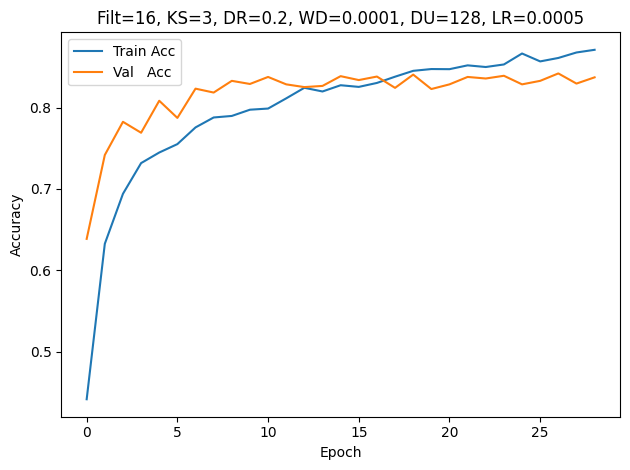

--> Best val_acc: 0.8419 for config: {'filters': 16, 'kernel_size': 3, 'dropout_rate': 0.2, 'weight_decay': 0.0001, 'dense_units': 128, 'lr': 0.0005}



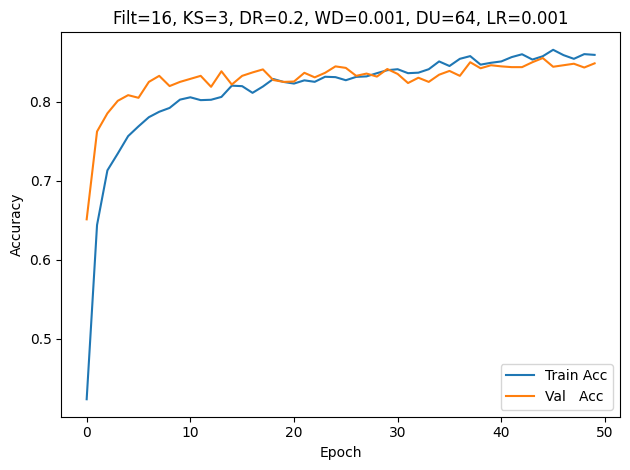

--> Best val_acc: 0.8553 for config: {'filters': 16, 'kernel_size': 3, 'dropout_rate': 0.2, 'weight_decay': 0.001, 'dense_units': 64, 'lr': 0.001}



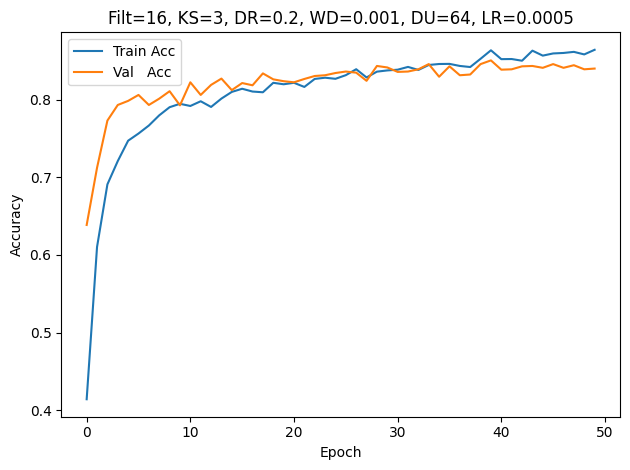

--> Best val_acc: 0.8510 for config: {'filters': 16, 'kernel_size': 3, 'dropout_rate': 0.2, 'weight_decay': 0.001, 'dense_units': 64, 'lr': 0.0005}



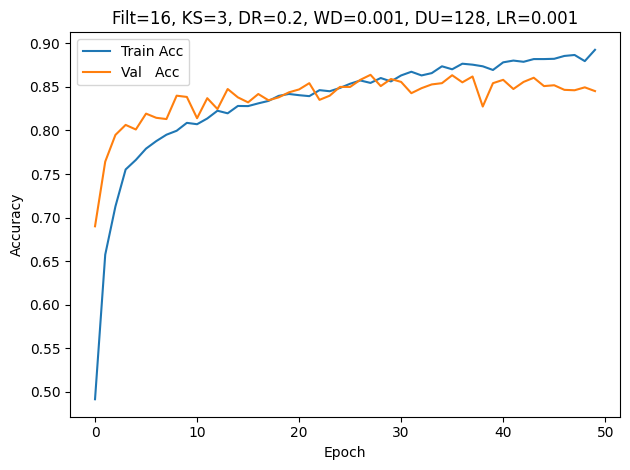

--> Best val_acc: 0.8639 for config: {'filters': 16, 'kernel_size': 3, 'dropout_rate': 0.2, 'weight_decay': 0.001, 'dense_units': 128, 'lr': 0.001}



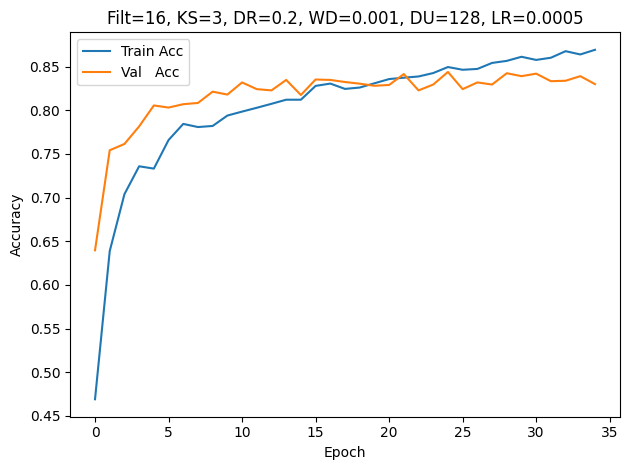

--> Best val_acc: 0.8438 for config: {'filters': 16, 'kernel_size': 3, 'dropout_rate': 0.2, 'weight_decay': 0.001, 'dense_units': 128, 'lr': 0.0005}



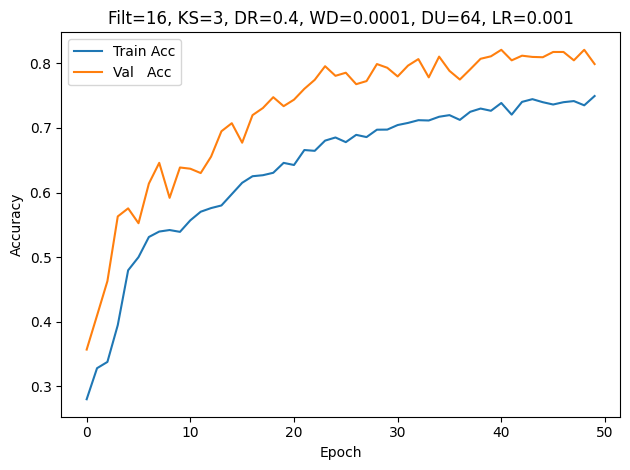

--> Best val_acc: 0.8208 for config: {'filters': 16, 'kernel_size': 3, 'dropout_rate': 0.4, 'weight_decay': 0.0001, 'dense_units': 64, 'lr': 0.001}



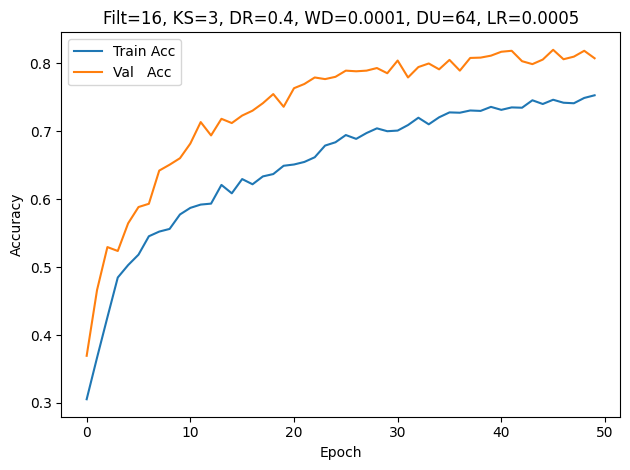

--> Best val_acc: 0.8198 for config: {'filters': 16, 'kernel_size': 3, 'dropout_rate': 0.4, 'weight_decay': 0.0001, 'dense_units': 64, 'lr': 0.0005}



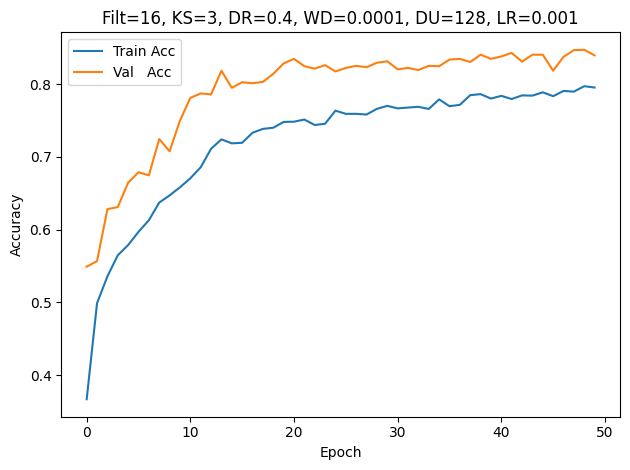

--> Best val_acc: 0.8471 for config: {'filters': 16, 'kernel_size': 3, 'dropout_rate': 0.4, 'weight_decay': 0.0001, 'dense_units': 128, 'lr': 0.001}



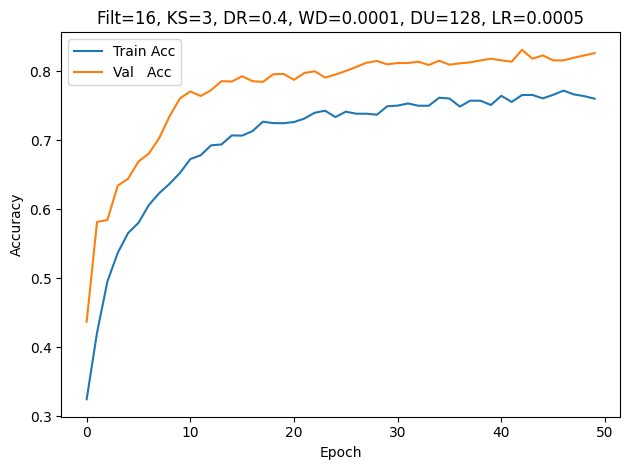

--> Best val_acc: 0.8313 for config: {'filters': 16, 'kernel_size': 3, 'dropout_rate': 0.4, 'weight_decay': 0.0001, 'dense_units': 128, 'lr': 0.0005}



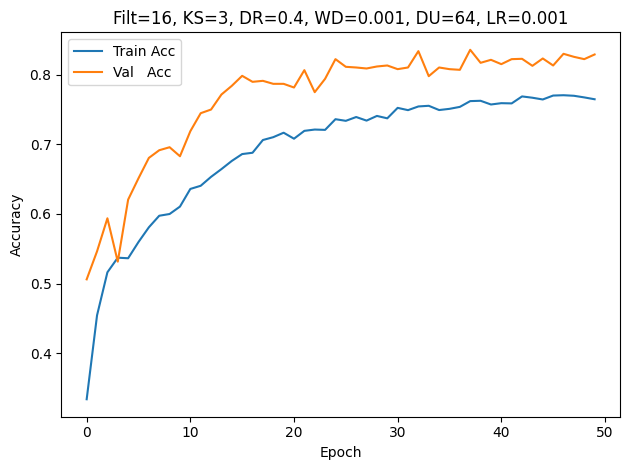

--> Best val_acc: 0.8356 for config: {'filters': 16, 'kernel_size': 3, 'dropout_rate': 0.4, 'weight_decay': 0.001, 'dense_units': 64, 'lr': 0.001}



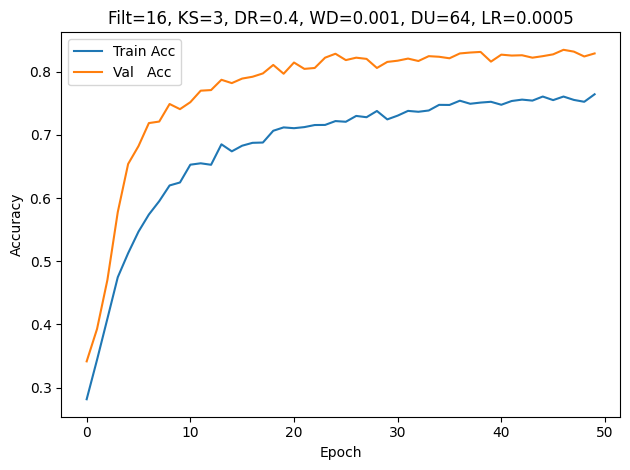

--> Best val_acc: 0.8347 for config: {'filters': 16, 'kernel_size': 3, 'dropout_rate': 0.4, 'weight_decay': 0.001, 'dense_units': 64, 'lr': 0.0005}



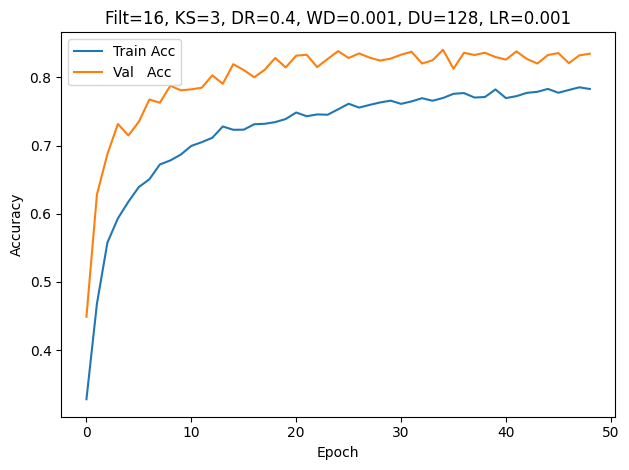

--> Best val_acc: 0.8404 for config: {'filters': 16, 'kernel_size': 3, 'dropout_rate': 0.4, 'weight_decay': 0.001, 'dense_units': 128, 'lr': 0.001}



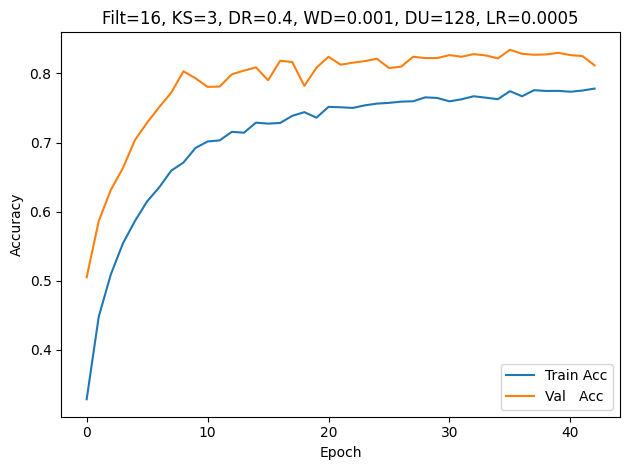

--> Best val_acc: 0.8342 for config: {'filters': 16, 'kernel_size': 3, 'dropout_rate': 0.4, 'weight_decay': 0.001, 'dense_units': 128, 'lr': 0.0005}



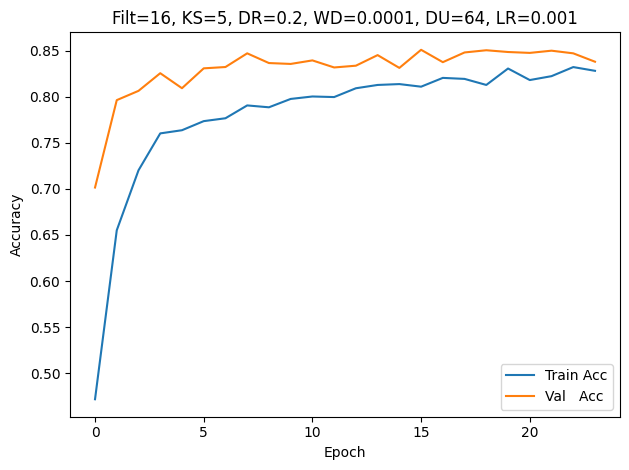

--> Best val_acc: 0.8510 for config: {'filters': 16, 'kernel_size': 5, 'dropout_rate': 0.2, 'weight_decay': 0.0001, 'dense_units': 64, 'lr': 0.001}



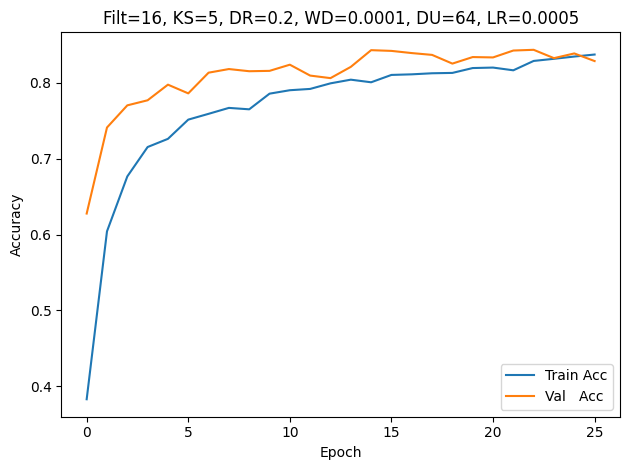

--> Best val_acc: 0.8438 for config: {'filters': 16, 'kernel_size': 5, 'dropout_rate': 0.2, 'weight_decay': 0.0001, 'dense_units': 64, 'lr': 0.0005}



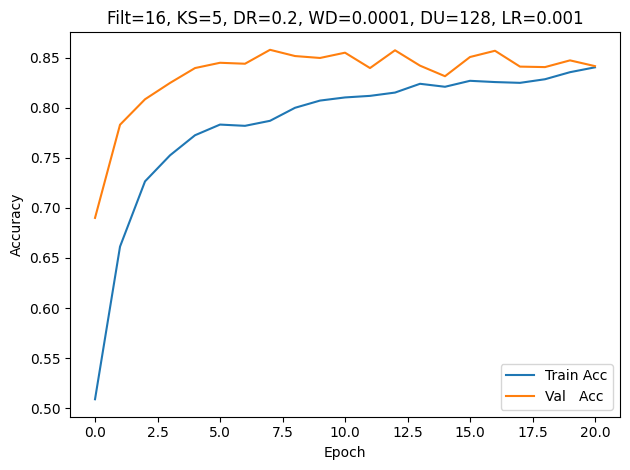

--> Best val_acc: 0.8577 for config: {'filters': 16, 'kernel_size': 5, 'dropout_rate': 0.2, 'weight_decay': 0.0001, 'dense_units': 128, 'lr': 0.001}



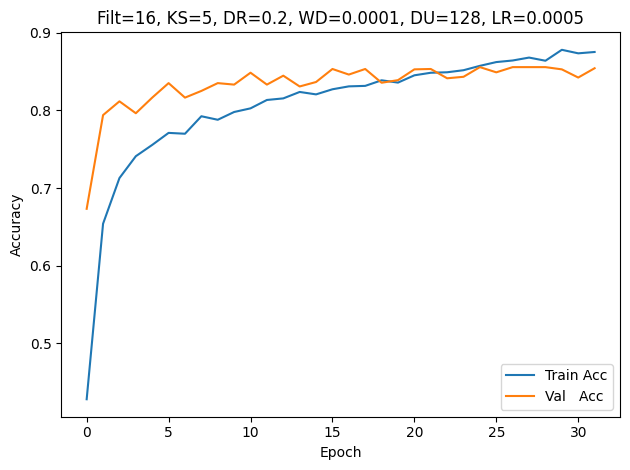

--> Best val_acc: 0.8558 for config: {'filters': 16, 'kernel_size': 5, 'dropout_rate': 0.2, 'weight_decay': 0.0001, 'dense_units': 128, 'lr': 0.0005}



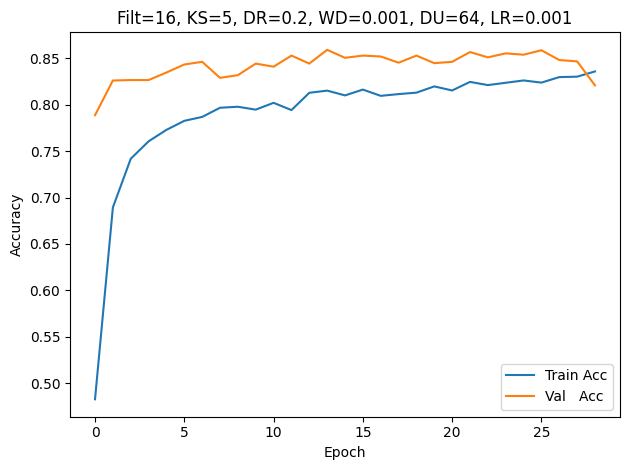

--> Best val_acc: 0.8591 for config: {'filters': 16, 'kernel_size': 5, 'dropout_rate': 0.2, 'weight_decay': 0.001, 'dense_units': 64, 'lr': 0.001}



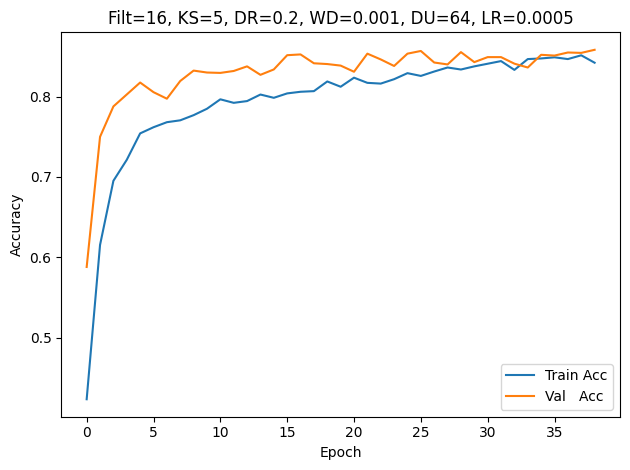

--> Best val_acc: 0.8582 for config: {'filters': 16, 'kernel_size': 5, 'dropout_rate': 0.2, 'weight_decay': 0.001, 'dense_units': 64, 'lr': 0.0005}



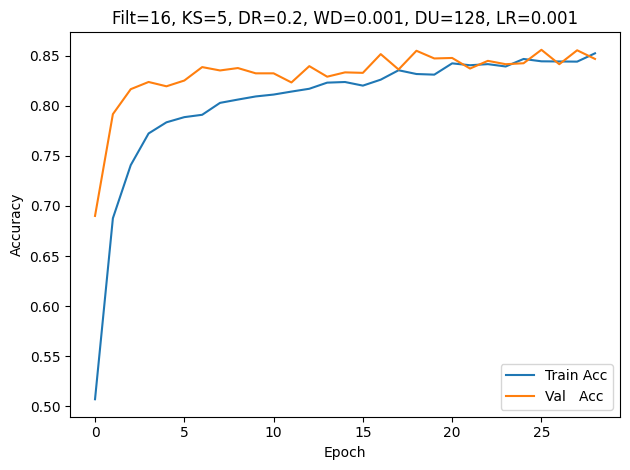

--> Best val_acc: 0.8558 for config: {'filters': 16, 'kernel_size': 5, 'dropout_rate': 0.2, 'weight_decay': 0.001, 'dense_units': 128, 'lr': 0.001}



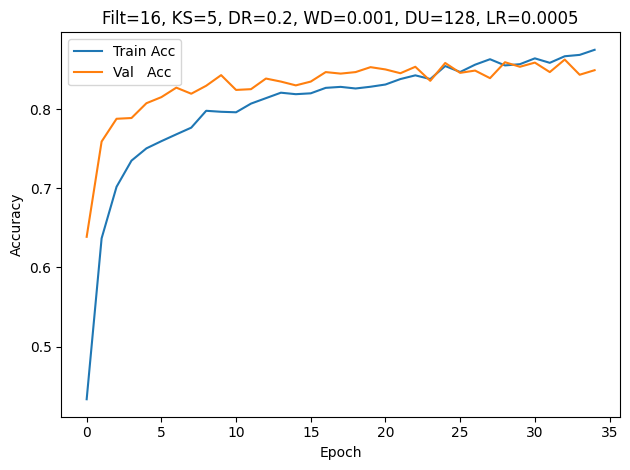

--> Best val_acc: 0.8625 for config: {'filters': 16, 'kernel_size': 5, 'dropout_rate': 0.2, 'weight_decay': 0.001, 'dense_units': 128, 'lr': 0.0005}



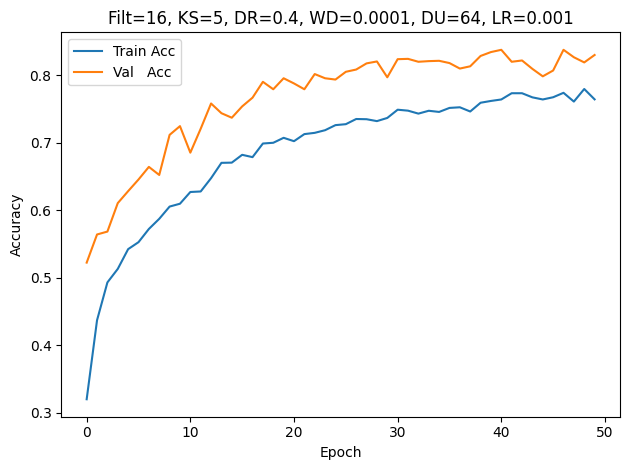

--> Best val_acc: 0.8380 for config: {'filters': 16, 'kernel_size': 5, 'dropout_rate': 0.4, 'weight_decay': 0.0001, 'dense_units': 64, 'lr': 0.001}



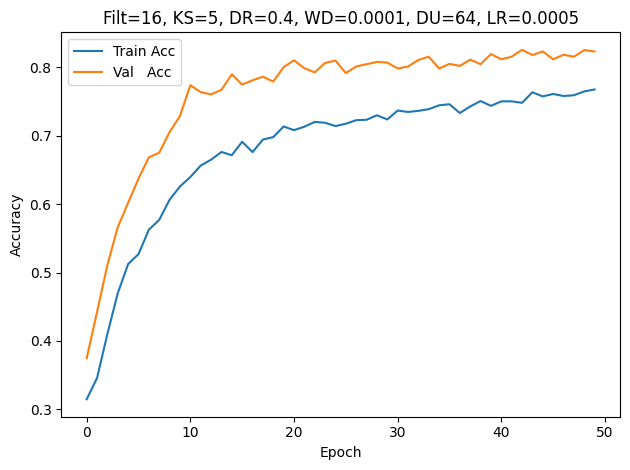

--> Best val_acc: 0.8256 for config: {'filters': 16, 'kernel_size': 5, 'dropout_rate': 0.4, 'weight_decay': 0.0001, 'dense_units': 64, 'lr': 0.0005}



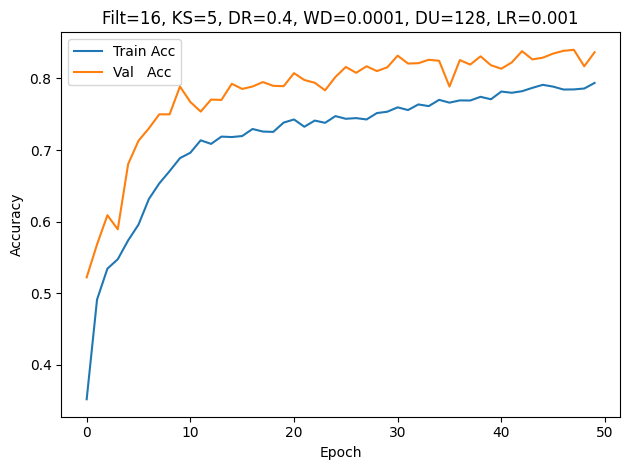

--> Best val_acc: 0.8400 for config: {'filters': 16, 'kernel_size': 5, 'dropout_rate': 0.4, 'weight_decay': 0.0001, 'dense_units': 128, 'lr': 0.001}



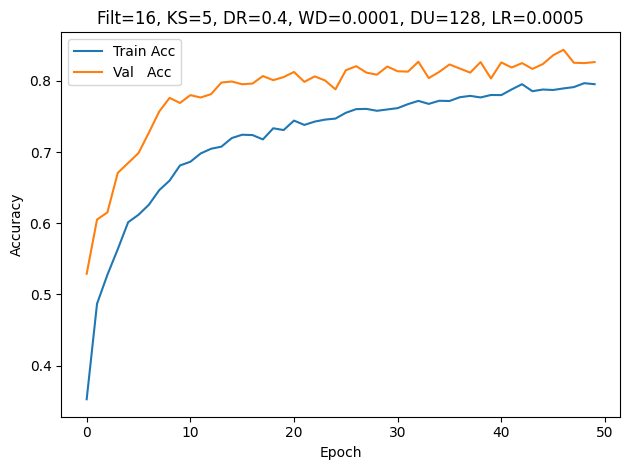

--> Best val_acc: 0.8438 for config: {'filters': 16, 'kernel_size': 5, 'dropout_rate': 0.4, 'weight_decay': 0.0001, 'dense_units': 128, 'lr': 0.0005}



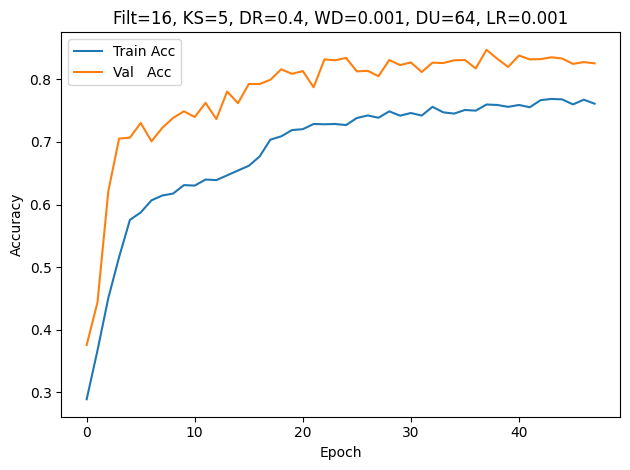

--> Best val_acc: 0.8471 for config: {'filters': 16, 'kernel_size': 5, 'dropout_rate': 0.4, 'weight_decay': 0.001, 'dense_units': 64, 'lr': 0.001}



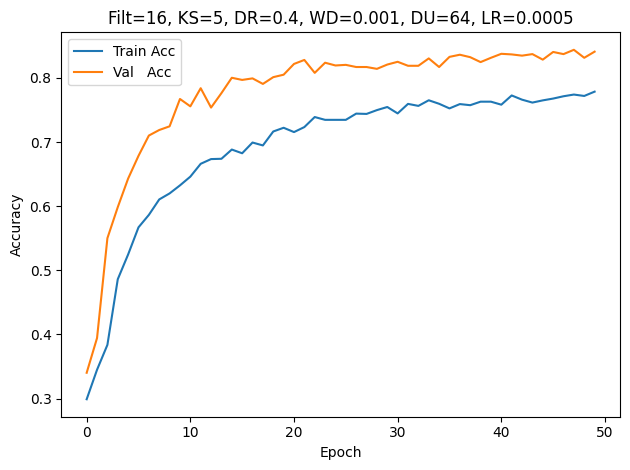

--> Best val_acc: 0.8438 for config: {'filters': 16, 'kernel_size': 5, 'dropout_rate': 0.4, 'weight_decay': 0.001, 'dense_units': 64, 'lr': 0.0005}



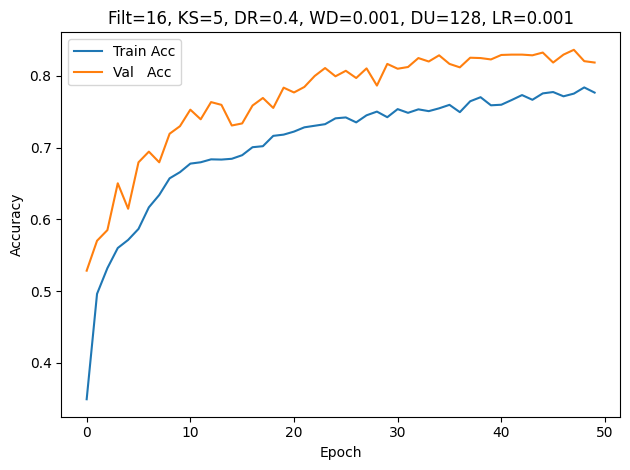

--> Best val_acc: 0.8361 for config: {'filters': 16, 'kernel_size': 5, 'dropout_rate': 0.4, 'weight_decay': 0.001, 'dense_units': 128, 'lr': 0.001}



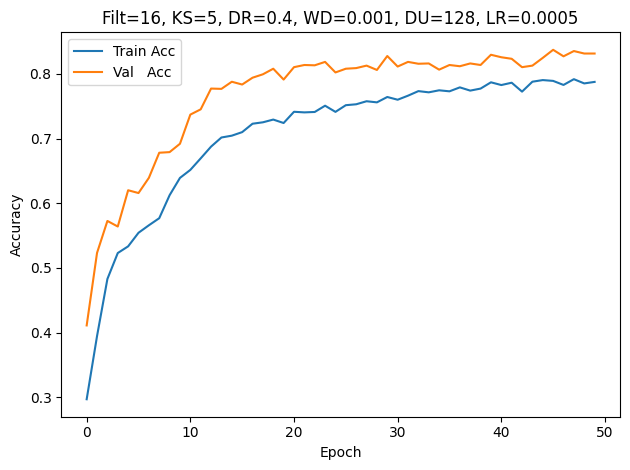

--> Best val_acc: 0.8371 for config: {'filters': 16, 'kernel_size': 5, 'dropout_rate': 0.4, 'weight_decay': 0.001, 'dense_units': 128, 'lr': 0.0005}



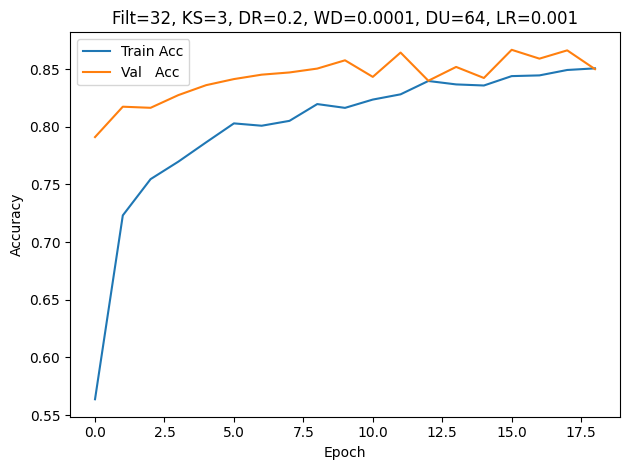

--> Best val_acc: 0.8668 for config: {'filters': 32, 'kernel_size': 3, 'dropout_rate': 0.2, 'weight_decay': 0.0001, 'dense_units': 64, 'lr': 0.001}



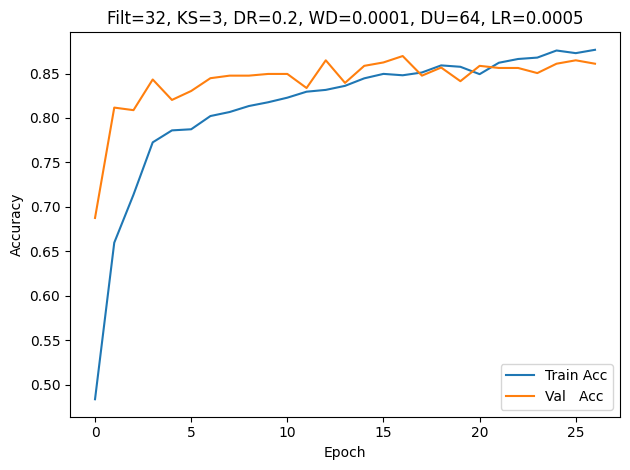

--> Best val_acc: 0.8697 for config: {'filters': 32, 'kernel_size': 3, 'dropout_rate': 0.2, 'weight_decay': 0.0001, 'dense_units': 64, 'lr': 0.0005}



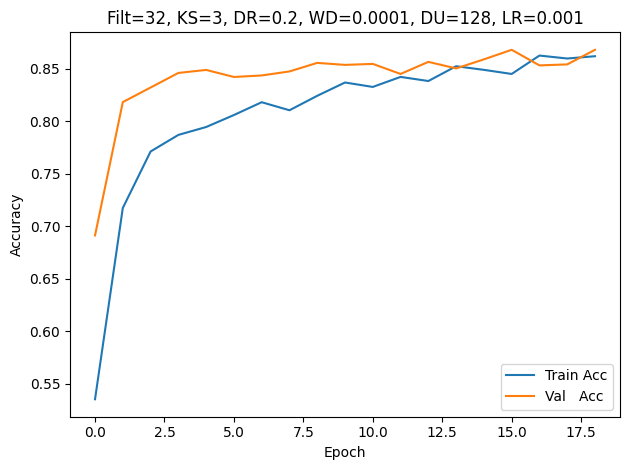

--> Best val_acc: 0.8682 for config: {'filters': 32, 'kernel_size': 3, 'dropout_rate': 0.2, 'weight_decay': 0.0001, 'dense_units': 128, 'lr': 0.001}



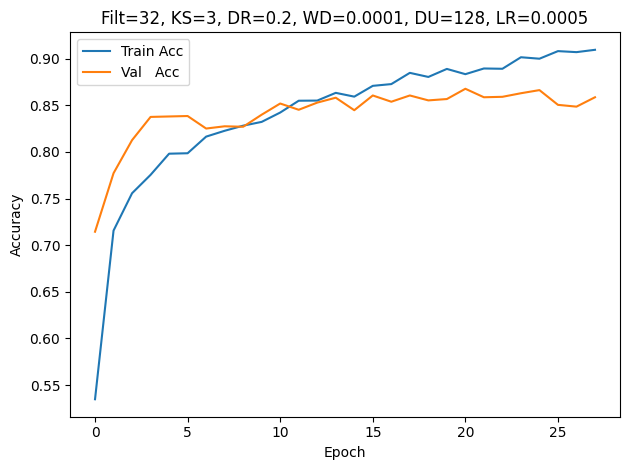

--> Best val_acc: 0.8678 for config: {'filters': 32, 'kernel_size': 3, 'dropout_rate': 0.2, 'weight_decay': 0.0001, 'dense_units': 128, 'lr': 0.0005}



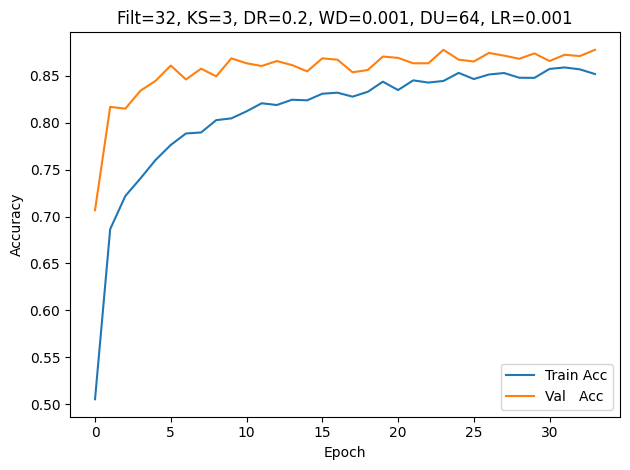

--> Best val_acc: 0.8778 for config: {'filters': 32, 'kernel_size': 3, 'dropout_rate': 0.2, 'weight_decay': 0.001, 'dense_units': 64, 'lr': 0.001}



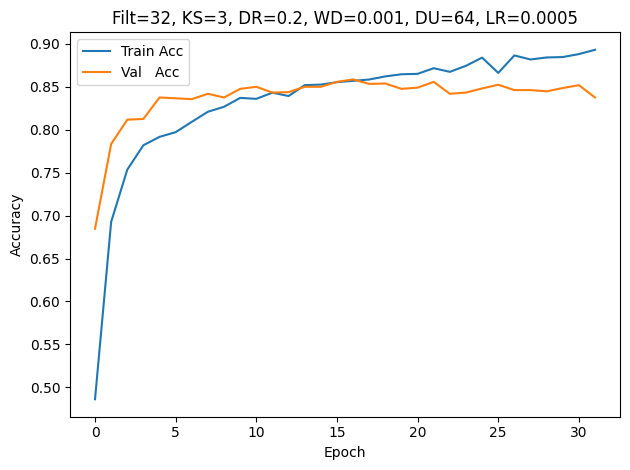

--> Best val_acc: 0.8586 for config: {'filters': 32, 'kernel_size': 3, 'dropout_rate': 0.2, 'weight_decay': 0.001, 'dense_units': 64, 'lr': 0.0005}



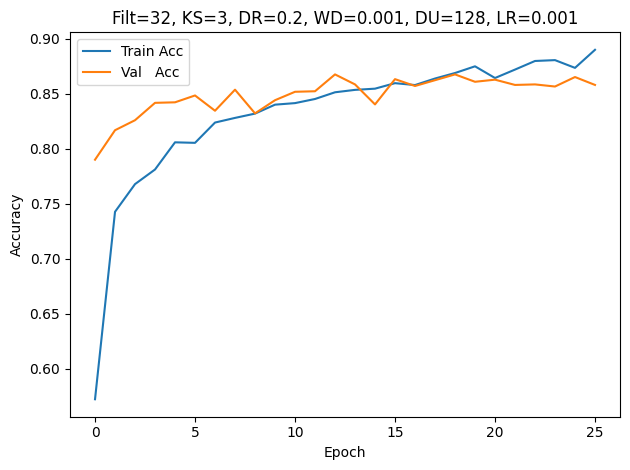

--> Best val_acc: 0.8678 for config: {'filters': 32, 'kernel_size': 3, 'dropout_rate': 0.2, 'weight_decay': 0.001, 'dense_units': 128, 'lr': 0.001}



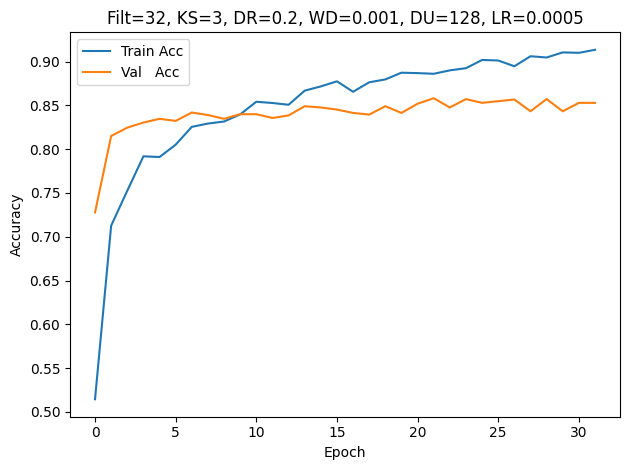

--> Best val_acc: 0.8582 for config: {'filters': 32, 'kernel_size': 3, 'dropout_rate': 0.2, 'weight_decay': 0.001, 'dense_units': 128, 'lr': 0.0005}



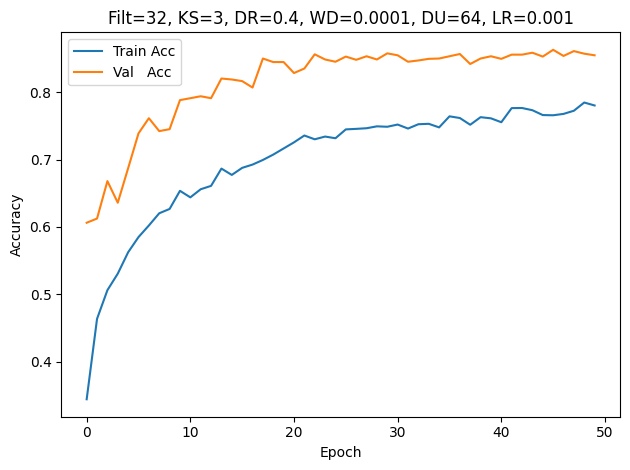

--> Best val_acc: 0.8630 for config: {'filters': 32, 'kernel_size': 3, 'dropout_rate': 0.4, 'weight_decay': 0.0001, 'dense_units': 64, 'lr': 0.001}



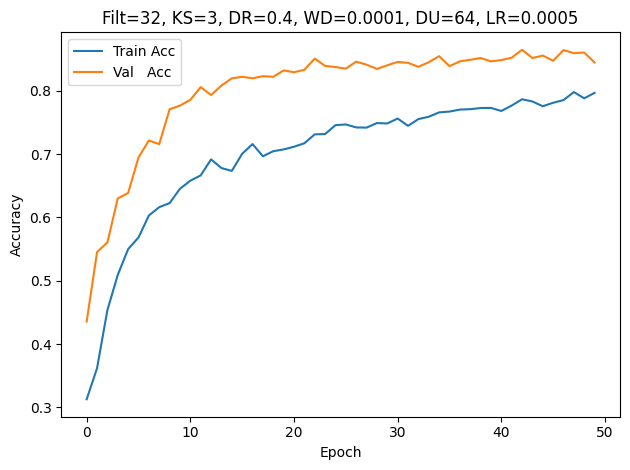

--> Best val_acc: 0.8649 for config: {'filters': 32, 'kernel_size': 3, 'dropout_rate': 0.4, 'weight_decay': 0.0001, 'dense_units': 64, 'lr': 0.0005}



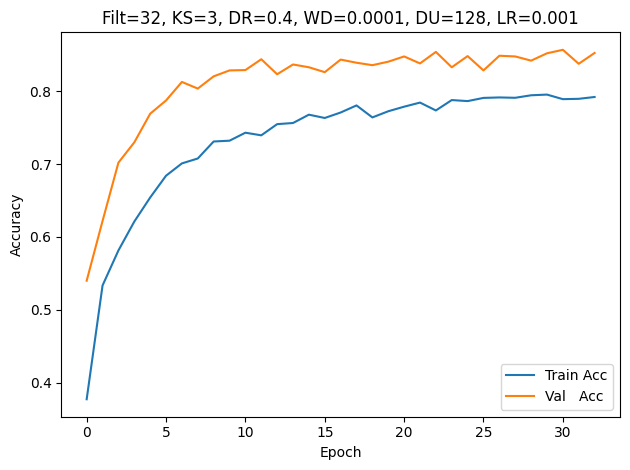

--> Best val_acc: 0.8567 for config: {'filters': 32, 'kernel_size': 3, 'dropout_rate': 0.4, 'weight_decay': 0.0001, 'dense_units': 128, 'lr': 0.001}



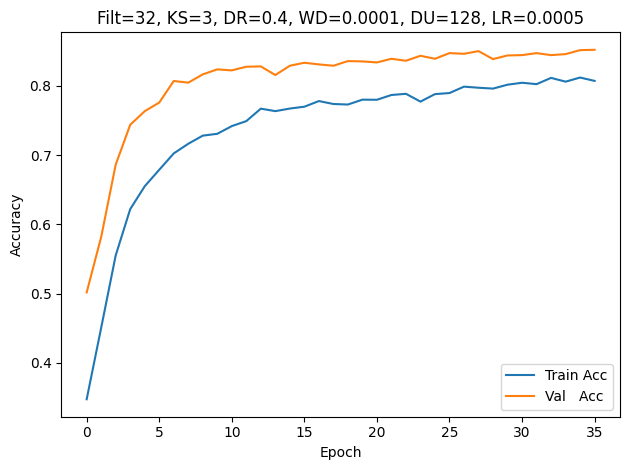

--> Best val_acc: 0.8519 for config: {'filters': 32, 'kernel_size': 3, 'dropout_rate': 0.4, 'weight_decay': 0.0001, 'dense_units': 128, 'lr': 0.0005}



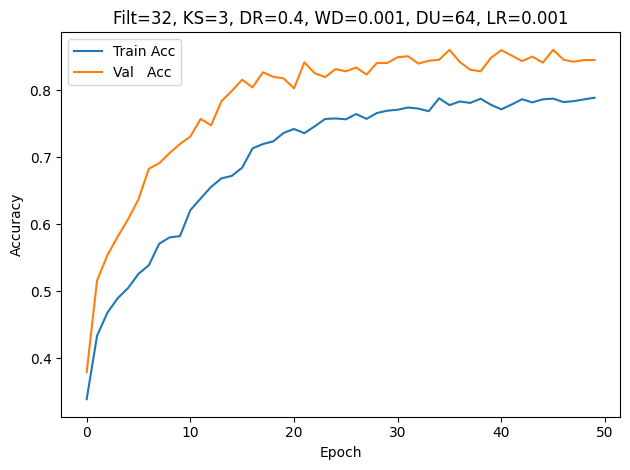

--> Best val_acc: 0.8601 for config: {'filters': 32, 'kernel_size': 3, 'dropout_rate': 0.4, 'weight_decay': 0.001, 'dense_units': 64, 'lr': 0.001}



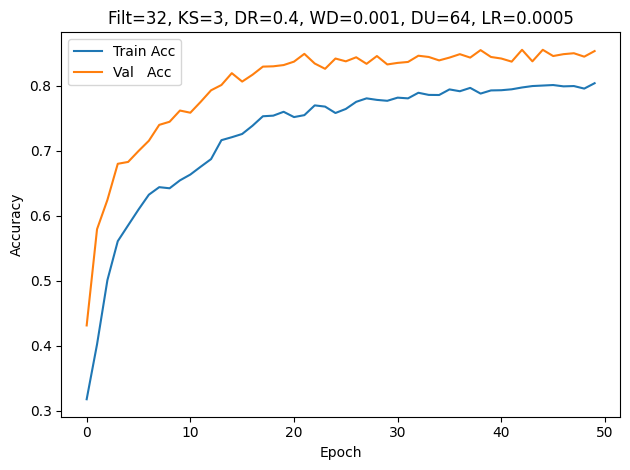

--> Best val_acc: 0.8553 for config: {'filters': 32, 'kernel_size': 3, 'dropout_rate': 0.4, 'weight_decay': 0.001, 'dense_units': 64, 'lr': 0.0005}



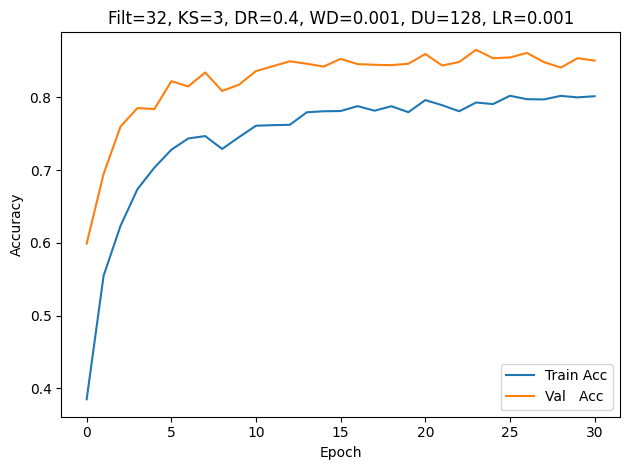

--> Best val_acc: 0.8654 for config: {'filters': 32, 'kernel_size': 3, 'dropout_rate': 0.4, 'weight_decay': 0.001, 'dense_units': 128, 'lr': 0.001}



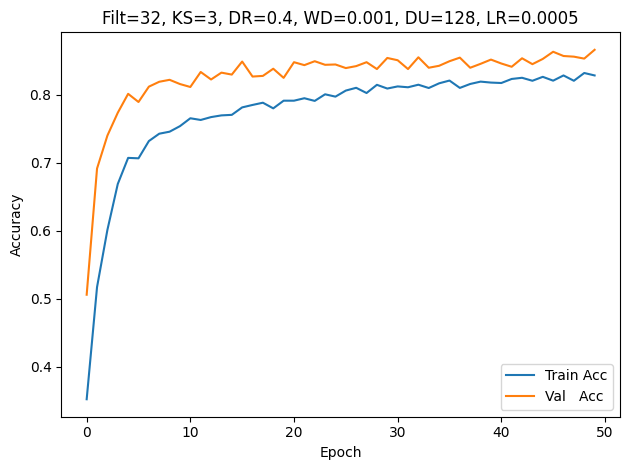

--> Best val_acc: 0.8658 for config: {'filters': 32, 'kernel_size': 3, 'dropout_rate': 0.4, 'weight_decay': 0.001, 'dense_units': 128, 'lr': 0.0005}



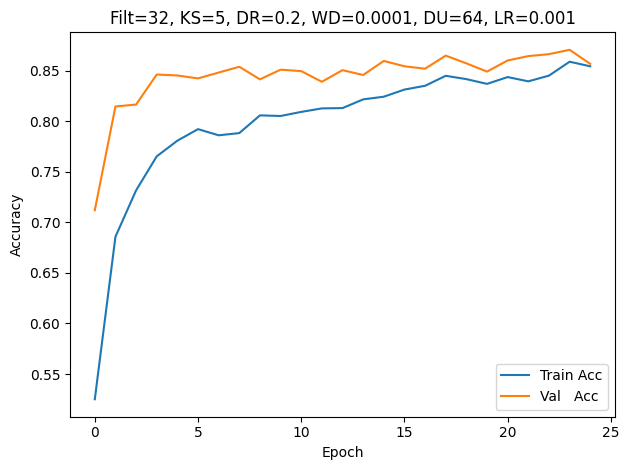

--> Best val_acc: 0.8706 for config: {'filters': 32, 'kernel_size': 5, 'dropout_rate': 0.2, 'weight_decay': 0.0001, 'dense_units': 64, 'lr': 0.001}



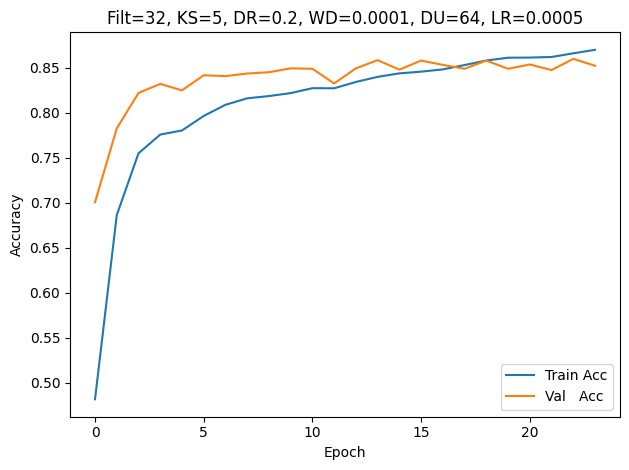

--> Best val_acc: 0.8596 for config: {'filters': 32, 'kernel_size': 5, 'dropout_rate': 0.2, 'weight_decay': 0.0001, 'dense_units': 64, 'lr': 0.0005}



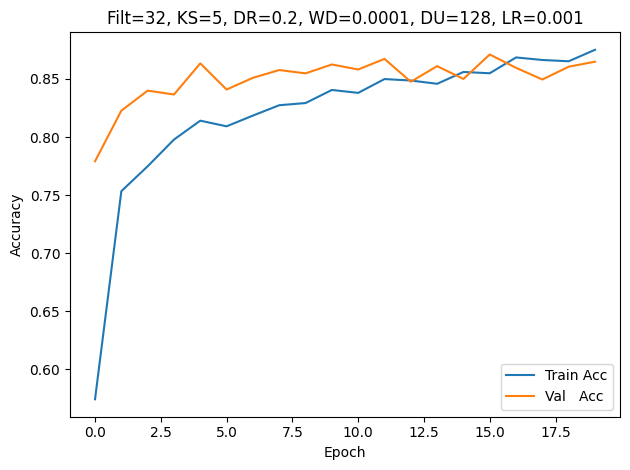

--> Best val_acc: 0.8711 for config: {'filters': 32, 'kernel_size': 5, 'dropout_rate': 0.2, 'weight_decay': 0.0001, 'dense_units': 128, 'lr': 0.001}



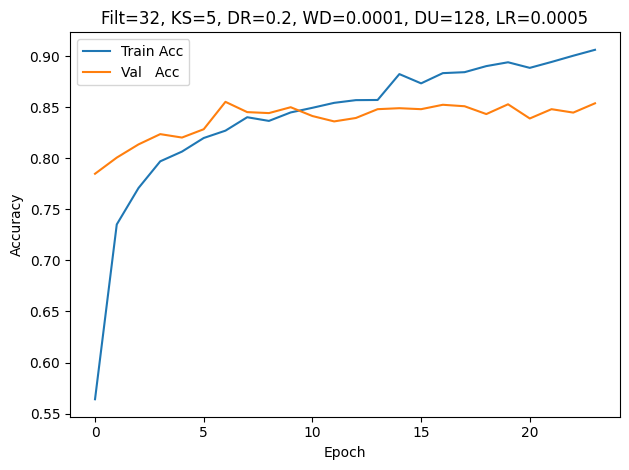

--> Best val_acc: 0.8553 for config: {'filters': 32, 'kernel_size': 5, 'dropout_rate': 0.2, 'weight_decay': 0.0001, 'dense_units': 128, 'lr': 0.0005}



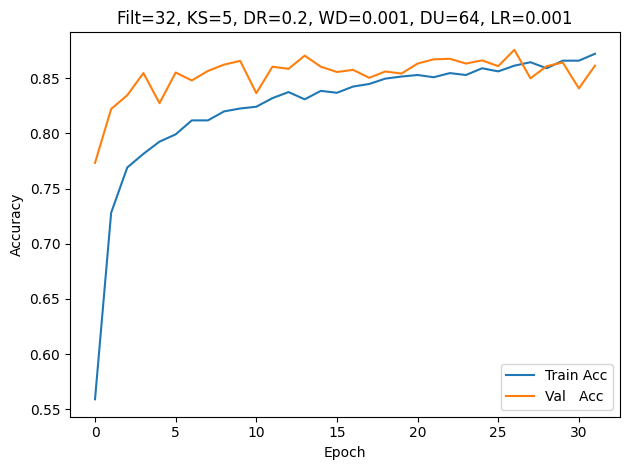

--> Best val_acc: 0.8759 for config: {'filters': 32, 'kernel_size': 5, 'dropout_rate': 0.2, 'weight_decay': 0.001, 'dense_units': 64, 'lr': 0.001}



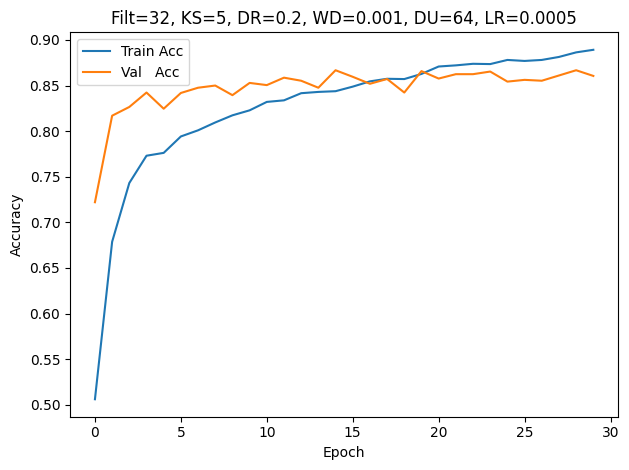

--> Best val_acc: 0.8668 for config: {'filters': 32, 'kernel_size': 5, 'dropout_rate': 0.2, 'weight_decay': 0.001, 'dense_units': 64, 'lr': 0.0005}



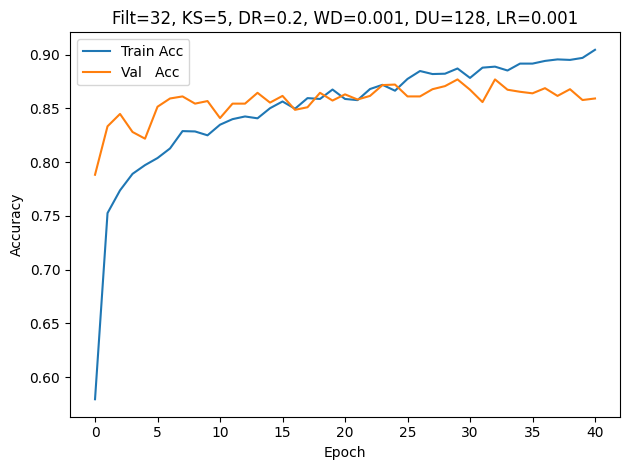

--> Best val_acc: 0.8769 for config: {'filters': 32, 'kernel_size': 5, 'dropout_rate': 0.2, 'weight_decay': 0.001, 'dense_units': 128, 'lr': 0.001}



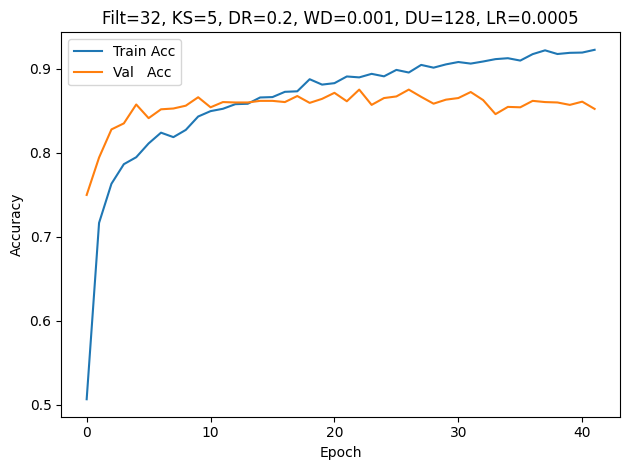

--> Best val_acc: 0.8754 for config: {'filters': 32, 'kernel_size': 5, 'dropout_rate': 0.2, 'weight_decay': 0.001, 'dense_units': 128, 'lr': 0.0005}



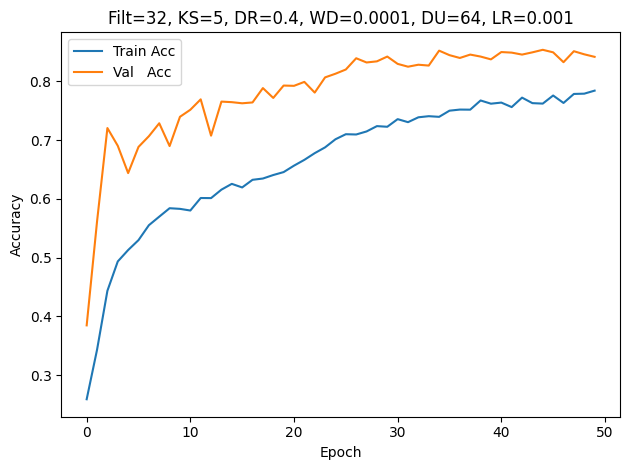

--> Best val_acc: 0.8539 for config: {'filters': 32, 'kernel_size': 5, 'dropout_rate': 0.4, 'weight_decay': 0.0001, 'dense_units': 64, 'lr': 0.001}



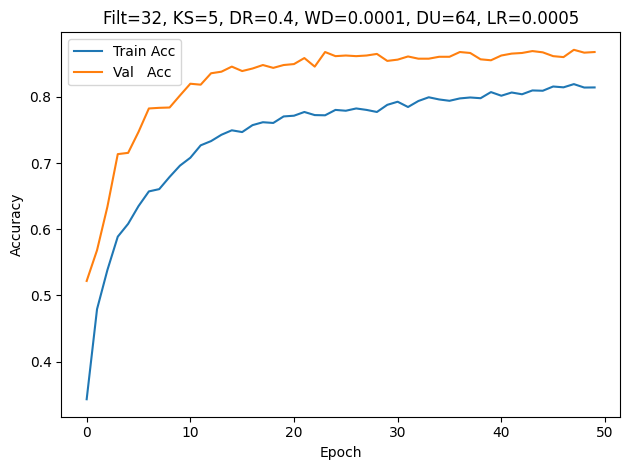

--> Best val_acc: 0.8711 for config: {'filters': 32, 'kernel_size': 5, 'dropout_rate': 0.4, 'weight_decay': 0.0001, 'dense_units': 64, 'lr': 0.0005}



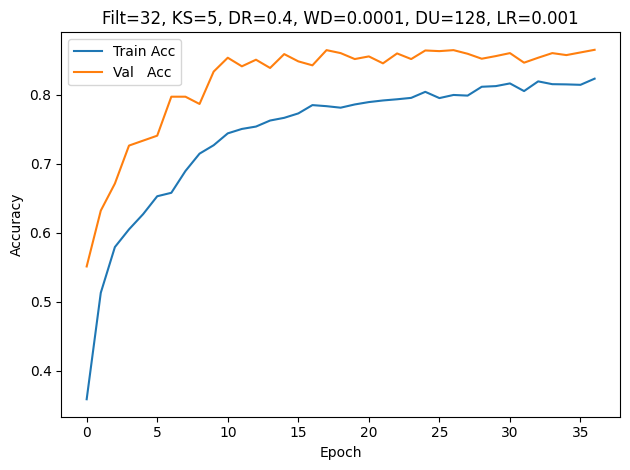

--> Best val_acc: 0.8654 for config: {'filters': 32, 'kernel_size': 5, 'dropout_rate': 0.4, 'weight_decay': 0.0001, 'dense_units': 128, 'lr': 0.001}



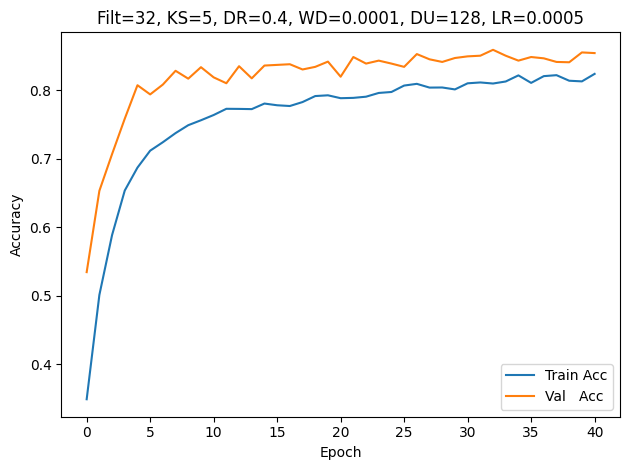

--> Best val_acc: 0.8591 for config: {'filters': 32, 'kernel_size': 5, 'dropout_rate': 0.4, 'weight_decay': 0.0001, 'dense_units': 128, 'lr': 0.0005}



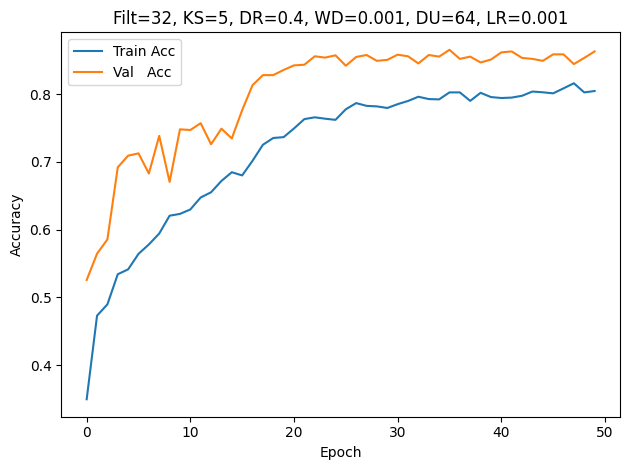

--> Best val_acc: 0.8654 for config: {'filters': 32, 'kernel_size': 5, 'dropout_rate': 0.4, 'weight_decay': 0.001, 'dense_units': 64, 'lr': 0.001}



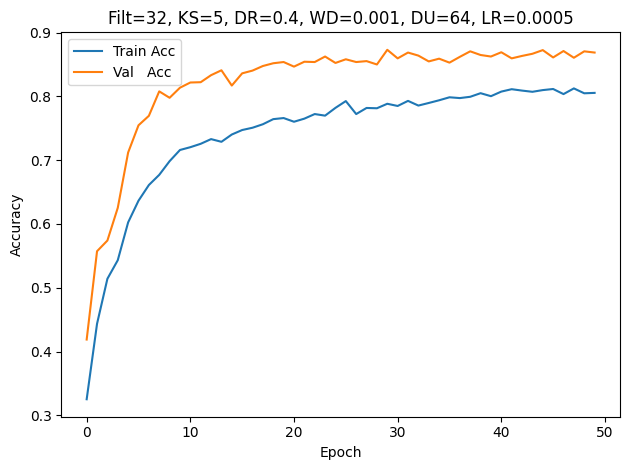

--> Best val_acc: 0.8730 for config: {'filters': 32, 'kernel_size': 5, 'dropout_rate': 0.4, 'weight_decay': 0.001, 'dense_units': 64, 'lr': 0.0005}



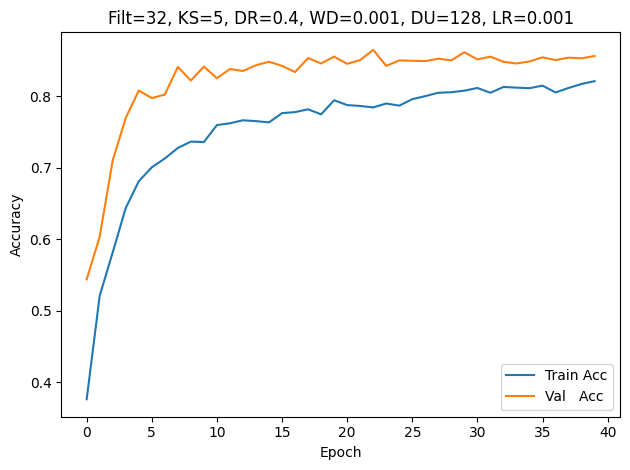

--> Best val_acc: 0.8654 for config: {'filters': 32, 'kernel_size': 5, 'dropout_rate': 0.4, 'weight_decay': 0.001, 'dense_units': 128, 'lr': 0.001}



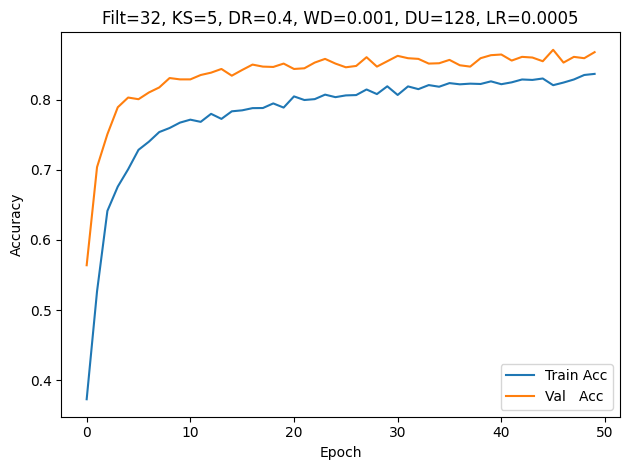

--> Best val_acc: 0.8711 for config: {'filters': 32, 'kernel_size': 5, 'dropout_rate': 0.4, 'weight_decay': 0.001, 'dense_units': 128, 'lr': 0.0005}



In [ ]:

# Hyperparameter grid
grid = {
    'filters':      [16, 32],
    'kernel_size':  [3, 5],
    'dropout_rate': [0.2, 0.4],
    'weight_decay': [1e-4, 1e-3],
    'dense_units':  [64, 128],
    'lr':           [1e-3, 5e-4]
}

# Prepare all combinations
keys, values = zip(*grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# EarlyStopping callback
cb_es = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=0
)

# Loop over hyperparameter combinations
for params in tqdm(combinations, desc="Hyperparam search"):

    f   = params['filters']
    ks  = params['kernel_size']
    dr  = params['dropout_rate']
    wd  = params['weight_decay']
    du  = params['dense_units']
    lr  = params['lr']

    # Build & train
    model = build_model(f, ks, dr, wd, du, lr)
    history = model.fit(
        X_train, y_train_enc,
        validation_data=(X_val, y_val_enc),
        epochs=50,
        batch_size=32,
        callbacks=[cb_es],
        verbose=0
    )

    # Plot train vs val accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val   Acc')
    plt.title(f"Filt={f}, KS={ks}, DR={dr}, WD={wd}, DU={du}, LR={lr}")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    best_val = max(history.history['val_accuracy'])
    print(f"--> Best val_acc: {best_val:.4f} for config: {params}\n")


## Testing of the best model selection
Now the model is rebuilt using the chosen parameters selection.

In [ ]:
# Model hyperparameters
filters       = 32         # Number of filters for Conv1D layers
kernel_size   = 3          # Kernel size for convolutions
dropout_rate  = 0.5        # Dropout rate for regularization
weight_decay  = 2e-3       # L2 regularization to prevent overfitting
dense_units   = 64         # Units in the dense (fully connected) layer
initial_lr    = 5e-4       # Initial learning rate for the optimizer

# Input shape info
timesteps, n_channels = X_train.shape[1], X_train.shape[2]

# Define the model architecture
model = Sequential([
    Input(shape=(timesteps, n_channels)),

    # First Conv block
    Conv1D(filters, kernel_size, activation='relu', kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    SpatialDropout1D(dropout_rate),

    # Second Conv block
    Conv1D(filters, kernel_size, activation='relu', kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(dropout_rate),

    # Third Conv block with double filters
    Conv1D(filters * 2, kernel_size, activation='relu', kernel_regularizer=l2(weight_decay)),
    MaxPooling1D(2),
    Dropout(dropout_rate),

    # Flatten and dense layers
    Flatten(),
    Dense(dense_units, activation='relu', kernel_regularizer=l2(weight_decay)),
    Dropout(dropout_rate),

    # Output layer with softmax for multi-class classification
    Dense(num_classes, activation='softmax')
])

# Compile the model with Adam optimizer and cross-entropy loss
optimizer = Adam(learning_rate=initial_lr)
model.compile(optimizer, 'categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Set up training callbacks
cb_es  = EarlyStopping('val_loss', patience=15, restore_best_weights=True)    # Stop early if no improvement
cb_rlr = ReduceLROnPlateau('val_loss', factor=0.5, patience=10, min_lr=1e-6)  # Reduce LR on plateau
eval_cb = EvalTrainVal(train_data=(X_train, y_train_enc), val_data=(X_val, y_val_enc))  # Custom evaluation

# Train the model
history = model.fit(
    X_train, y_train_enc,
    epochs=99,
    batch_size=32,
    validation_data=(X_val, y_val_enc),
    callbacks=[cb_es, cb_rlr, eval_cb],
    verbose=1
)

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test_enc, verbose=0)
print(f"\nTest Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Predict and evaluate performance
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1) + offset
cm     = confusion_matrix(y_test, y_pred, labels=classes)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels=classes))


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 398, 32)        │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 398, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ (None, 398, 32)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 396, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 396, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 198, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 198, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 196, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 98, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 98, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 412,230 (1.57 MB)

 Trainable params: 412,102 (1.57 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/99
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1749 - loss: 2.4340 — eval_train_acc: 0.2987, eval_val_acc: 0.2868
223/223 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.1750 - loss: 2.4331 - val_accuracy: 0.2868 - val_loss: 2.0362 - learning_rate: 5.0000e-04
Epoch 2/99
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2721 - loss: 2.0248 — eval_train_acc: 0.3612, eval_val_acc: 0.3495
223/223 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.2722 - loss: 2.0246 - val_accuracy: 0.3495 - val_loss: 1.8722 - learning_rate: 5.0000e-04
Epoch 3/99
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3358 - loss: 1.8632 — eval_train_acc: 0.4882, eval_val_acc: 0.4734
223/223 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.3358 - loss: 1.8631 - val_accuracy: 0.4734 - val_loss: 1.7817 - learning_rate: 5.0000e-04
Epoch 4/99
222/223 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3634 - loss: 1.7466 — eval_train_acc: 0.5714, eval_val_acc: 0.5078
223/223 ━━━━━━━━━━━━━━━

## Window Size and Step Tunning

Grid search over different combinations of window sizes and step values to optimize segmentation

In [ ]:
# Define grid of (window size, step) combinations to test
window_sizes = [250, 400, 500]
steps        = [100, 175, 250]
grid = list(itertools.product(window_sizes, steps))


# Build windowed train/val/test datasets for a given window + step config
def make_datasets(window_size, train_step, val_step, test_step):
    train_w, val_w, test_w = {}, {}, {}

    for key, gdf in gesture_datasets.items():
        cols = [c for c in gdf.columns if c.startswith("channel")]
        sig  = gdf[cols].to_numpy().T  # shape: (channels, samples)

        # Route each gesture to its split and extract windows
        if   key in train_segs: step, target = train_step, train_w
        elif key in val_segs:   step, target = val_step,   val_w
        else:                   step, target = test_step,  test_w

        wins = extract_deterministic_windows(sig, window_size, step)
        for i, w in enumerate(wins):
            target[f"{key}_win_{i}"] = w

    # Helper to stack data and extract class labels
    def prepare(wdict):
        X = np.stack([w.T for w in wdict.values()], axis=0)
        y = np.array([int(k.split('_')[1]) for k in wdict.keys()])
        return X, y

    # Prepare all three splits
    X_tr, y_tr = prepare(train_w)
    X_va, y_va = prepare(val_w)
    X_te, y_te = prepare(test_w)

    # One-hot encode class labels
    classes_arr = np.unique(y_tr)
    offset      = classes_arr.min()
    num_classes = len(classes_arr)
    y_tr_enc = to_categorical(y_tr - offset, num_classes)
    y_va_enc = to_categorical(y_va - offset, num_classes)
    y_te_enc = to_categorical(y_te - offset, num_classes)

    # Normalize each split using train set statistics
    mean = X_tr.mean(axis=(0,1), keepdims=True)
    std  = X_tr.std(axis=(0,1), keepdims=True) + 1e-8
    for arr in (X_tr, X_va, X_te):
        arr[:] = (arr - mean) / std

    return (X_tr, y_tr_enc), (X_va, y_va_enc), (X_te, y_te_enc), (y_te, offset, num_classes)


# Build a 1D-CNN for gesture classification
def get_model(timesteps, n_channels, num_classes,
              filters=32, kernel_size=3, dropout_rate=0.5, weight_decay=2e-3, dense_units=64, lr=5e-4):
    model = Sequential([
        Input(shape=(timesteps, n_channels)),
        Conv1D(filters, kernel_size, activation='relu', kernel_regularizer=l2(weight_decay)),
        BatchNormalization(), SpatialDropout1D(dropout_rate),

        Conv1D(filters, kernel_size, activation='relu', kernel_regularizer=l2(weight_decay)),
        BatchNormalization(), MaxPooling1D(2), Dropout(dropout_rate),

        Conv1D(filters*2, kernel_size, activation='relu', kernel_regularizer=l2(weight_decay)),
        MaxPooling1D(2), Dropout(dropout_rate),

        Flatten(),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(weight_decay)),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# Run tuning over all (window, step) combinations
results = []
for win, step in grid:
    print(f"\n GRID: window={win}, step={step}")

    # Build datasets for current window config
    (X_tr, y_tr_enc), (X_va, y_va_enc), (X_te, y_te_enc), (y_te, offset, num_classes) = \
        make_datasets(window_size=win, train_step=step, val_step=step, test_step=step)

    # Build CNN model
    timesteps, n_ch = X_tr.shape[1], X_tr.shape[2]
    model = get_model(timesteps, n_ch, num_classes)

    # Callbacks: early stopping and learning rate reduction
    cb_es  = EarlyStopping('val_loss', patience=10, restore_best_weights=True, verbose=1)
    cb_rlr = ReduceLROnPlateau('val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    # Train the model
    history = model.fit(
        X_tr, y_tr_enc,
        validation_data=(X_va, y_va_enc),
        epochs=50,
        batch_size=32,
        callbacks=[cb_es, cb_rlr],
        verbose=2
    )

    # Plot training and validation accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'],     label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Accuracy (window={win}, step={step})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate on test set
    loss, acc = model.evaluate(X_te, y_te_enc, verbose=0)
    print(f"--> Test Acc: {acc:.4f}")

    # Save results
    results.append({'window_size': win, 'step': step, 'test_acc': acc})


# Summarize results in table
df_results = pd.DataFrame(results)
print("\nGrid search results:")
print(df_results.pivot(index='window_size', columns='step', values='test_acc'))


This final model reflects the best segmentation strategy and network architecture found during tuning

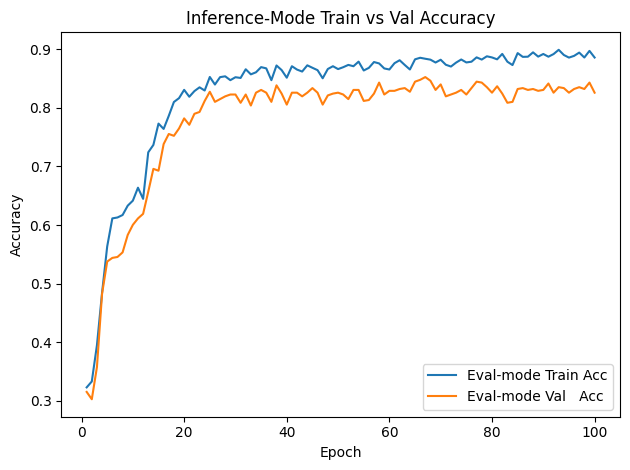

In [ ]:
# Plot eval-mode accuracies

plt.figure()
epochs = range(1, len(eval_cb.eval_metrics['train_acc'])+1)
plt.plot(epochs, eval_cb.eval_metrics['train_acc'], label='Eval-mode Train Acc')
plt.plot(epochs, eval_cb.eval_metrics['val_acc'],   label='Eval-mode Val   Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Inference-Mode Train vs Val Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


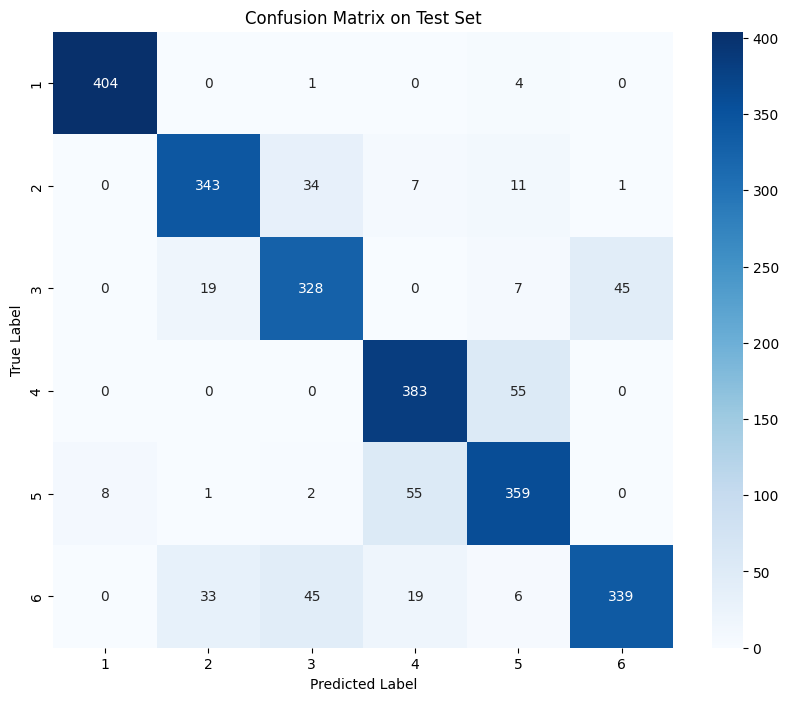


Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.99      0.98       409
           2       0.87      0.87      0.87       396
           3       0.80      0.82      0.81       399
           4       0.83      0.87      0.85       438
           5       0.81      0.84      0.83       425
           6       0.88      0.77      0.82       442

    accuracy                           0.86      2509
   macro avg       0.86      0.86      0.86      2509
weighted avg       0.86      0.86      0.86      2509



In [ ]:

# Predict class labels for test set
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1) + offset

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels=classes))


## Segment-level evaluation

Instead of looking at the windows, the original segments are recovered and to determine the label of each segment, majority vote is applied.

In [ ]:
# Predict window-wise classes
y_pred_test = np.argmax(model.predict(X_test, verbose=0), axis=1) + offset

# Map predictions back to segments
segment_preds = defaultdict(list)
segment_truth = {}

# Reconstruct segment keys from test_w keys
for i, key in enumerate(test_w.keys()):
    segment_id = '_'.join(key.split('_')[:3])
    true_class = int(segment_id.split('_')[1])
    segment_preds[segment_id].append(y_pred_test[i])
    segment_truth[segment_id] = true_class


In [ ]:
# Apply majority vote
segment_final_preds = {}
for segment_id, preds in segment_preds.items():
    most_common = Counter(preds).most_common(1)[0][0]
    segment_final_preds[segment_id] = most_common


Segment-Level Accuracy: 0.8278


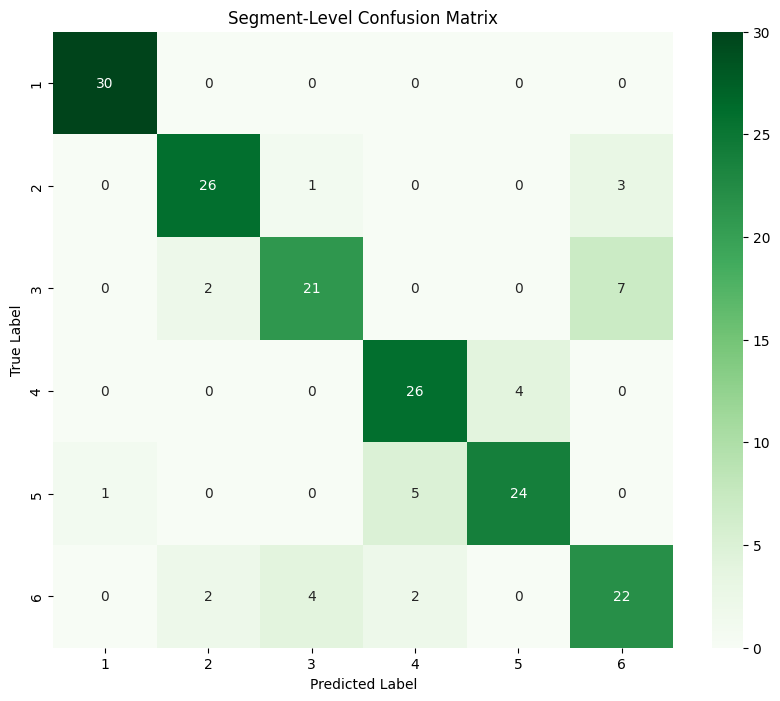


Segment-Level Classification Report:
              precision    recall  f1-score   support

           1       0.97      1.00      0.98        30
           2       0.87      0.87      0.87        30
           3       0.81      0.70      0.75        30
           4       0.79      0.87      0.83        30
           5       0.86      0.80      0.83        30
           6       0.69      0.73      0.71        30

    accuracy                           0.83       180
   macro avg       0.83      0.83      0.83       180
weighted avg       0.83      0.83      0.83       180



In [ ]:
# Extract true and predicted labels
y_true_seg = [segment_truth[sid] for sid in segment_final_preds]
y_pred_seg = [segment_final_preds[sid] for sid in segment_final_preds]

# Accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
seg_acc = accuracy_score(y_true_seg, y_pred_seg)
print(f"Segment-Level Accuracy: {seg_acc:.4f}")

# Confusion matrix
cm_seg = confusion_matrix(y_true_seg, y_pred_seg, labels=classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_seg, annot=True, fmt='d', cmap='Greens',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Segment-Level Confusion Matrix")
plt.show()

# report
print("\nSegment-Level Classification Report:")
print(classification_report(y_true_seg, y_pred_seg, labels=classes))
